In [40]:
import os
from tensorflow import keras
from tensorflow.keras  import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, Lambda, MaxPooling2D, AveragePooling2D, Dropout, Layer

from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from absl import app
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

In [41]:
import tensorflow_datasets as tfds
tf.compat.v1.disable_eager_execution()

In [42]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [43]:
model_dir = "BIRD_data/"
n_concept = 100
n_cluster = 5
n = 60000
batch_size = 128
pretrain = False
verbose = 2
thres = 0.2
seed = 0

In [44]:
train_directory='../data/cup_200_cropped/train_cropped_augmented2'
org_train_directory='../data/cup_200_cropped/train_cropped'
test_directory='../data/cup_200_cropped/test_cropped'

In [45]:
train_datagen=ImageDataGenerator(rescale=1/255,
                                 #horizontal_flip=True,
                                 #rotation_range=15,
                                 #shear_range=10,
)
test_datagen=ImageDataGenerator(rescale=1/255)

In [46]:
train_generator=train_datagen.flow_from_directory(train_directory,
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 shuffle=True,
                                                 seed=seed,
                                                 class_mode='sparse',batch_size=batch_size)

val_generator=test_datagen.flow_from_directory(test_directory,
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 shuffle=True,
                                                 seed=seed,
                                                 class_mode='sparse',batch_size=batch_size)

Found 179820 images belonging to 200 classes.
Found 5794 images belonging to 200 classes.


In [47]:
(221130 /30 - 5994 )/30

45.9

In [25]:
# Create the dataframe to sample from the augmented dataset
filenames = []
folders = os.listdir(train_directory)
for foldername in sorted(folders):
    files = os.listdir(train_directory+"/"+foldername)
    for filename in sorted(files):
        filenames.append(foldername+"/"+filename)
df = pd.DataFrame(filenames ,columns=["x_col"])
df["y_col"] = df["x_col"].map(lambda x: x.split(".")[0])

In [26]:
# Create the dataframe for the original dataset
filenames = []
folders = os.listdir(org_train_directory)
for foldername in sorted(folders):
    files = os.listdir(org_train_directory+"/"+foldername)
    for filename in sorted(files):
        filenames.append(foldername+"/"+filename)
org_df = pd.DataFrame(filenames ,columns=["x_col"])
org_df["y_col"] = org_df["x_col"].map(lambda x: x.split(".")[0])

In [27]:
# Create the dataframe for the test dataset
filenames = []
folders = os.listdir(test_directory)
for foldername in sorted(folders):
    files = os.listdir(test_directory+"/"+foldername)
    for filename in sorted(files):
        filenames.append(foldername+"/"+filename)
test_df = pd.DataFrame(filenames ,columns=["x_col"])
test_df["y_col"] = test_df["x_col"].map(lambda x: x.split(".")[0])

In [9]:
#convlayers =tf.keras.applications.ResNet50(
#    include_top=False,
#    weights="imagenet",
#    input_tensor=None,
#    input_shape=(224, 224, 3),
#    pooling=None,
#    classes=200,
#)



In [10]:
%load_ext autoreload
%autoreload 2
from ResNet34 import ResNet34

In [11]:
convlayers = ResNet34(input_shape=(224, 224, 3), input_tensor=None, weights='imagenet', include_top=False)
dense1 = Dense(200,activation='softmax')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [12]:
model=Sequential()
model.add(convlayers)
model.add(AveragePooling2D(7,7))
model.add(Flatten())
model.add(dense1)

In [13]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet34 (Model)             (None, 7, 7, 512)         21302473  
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               102600    
Total params: 21,405,073
Trainable params: 21,389,707
Non-trainable params: 15,366
_________________________________________________________________
None


In [14]:
opt=tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer=opt)

In [15]:
history=model.fit(train_generator,validation_data=val_generator,
         epochs=1)

1739/1739 [==============================] - 912s 524ms/step - loss: 0.4159 - accuracy: 0.9275 - val_loss: 1.0181 - val_accuracy: 0.7511


In [203]:
def load_model_stm_new(train_generator,val_generator, input_shape=(224, 224, 3),  verbose=True):
    """Loads pretrain model or train one."""
    convlayers = ResNet34(input_shape=input_shape, input_tensor=None, weights='imagenet', include_top=False)
    dense1 = Dense(200,activation='softmax')

    model=Sequential()
    model.add(convlayers)
    model.add(AveragePooling2D(7,7))
    model.add(Flatten())
    model.add(dense1)
    optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    opt=tf.keras.optimizers.Adam(lr=0.0001)
    model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer=opt)
    
    history=model.fit_generator(train_generator,validation_data=val_generator,
         epochs=10, verbose=verbose)
    
    for layer in model.layers:
        layer.trainable = False
    
    feature_model =  Sequential()
    feature_model.add(convlayers)
    feature_model.add(AveragePooling2D(7,7))
    predict_model  =  Sequential()
    predict_model.add(Flatten())
    predict_model.add(dense1)

    return feature_model, predict_model

In [13]:
feature_model, predict_model = load_model_stm_new(train_generator,val_generator)

47/47 [==============================] - 90s 2s/step - loss: 4.8984 - accuracy: 0.0809 - val_loss: 5.4750 - val_accuracy: 0.0035


In [105]:
def new_train_generator(seed,percentage,df,org_datasetsize,repetition=30):
    np.random.seed(seed)
    indices = np.random.choice(org_datasetsize, size=int(percentage*org_datasetsize), replace=False)
    augmented_indices = indices.repeat(repetition)*repetition+np.tile(np.arange(repetition),len(indices))
    train_generator =train_datagen.flow_from_dataframe(dataframe=df,
        directory=train_directory,
        x_col="x_col",
        y_col="y_col",
        target_size=(224,224),
        color_mode='rgb',
        shuffle=True,
        seed=seed,
        class_mode='sparse',batch_size=batch_size,
    )
    return train_generator, indices

In [114]:
type(train_generator)

keras_preprocessing.image.dataframe_iterator.DataFrameIterator

In [113]:
train_generator, indeces = new_train_generator(seed,percentage,df,org_datasetsize=len(org_df),repetition=30)

Found 179820 validated image filenames belonging to 200 classes.


In [204]:
feature_model, predict_model = load_model_stm_new(train_generator,val_generator)

Epoch 1/10
1405/1405 [==============================] - 766s 545ms/step - loss: 0.5133 - accuracy: 0.9124 - val_loss: 1.0143 - val_accuracy: 0.7558
Epoch 2/10
1405/1405 [==============================] - 700s 498ms/step - loss: 0.0171 - accuracy: 0.9974 - val_loss: 1.1447 - val_accuracy: 0.7318
Epoch 3/10
1405/1405 [==============================] - 701s 499ms/step - loss: 0.0163 - accuracy: 0.9970 - val_loss: 1.3336 - val_accuracy: 0.7097
Epoch 4/10
1405/1405 [==============================] - 699s 498ms/step - loss: 0.0151 - accuracy: 0.9969 - val_loss: 1.2771 - val_accuracy: 0.7278
Epoch 5/10
1405/1405 [==============================] - 699s 498ms/step - loss: 0.0112 - accuracy: 0.9976 - val_loss: 1.2412 - val_accuracy: 0.7366
Epoch 6/10
1405/1405 [==============================] - 700s 498ms/step - loss: 0.0101 - accuracy: 0.9977 - val_loss: 1.4129 - val_accuracy: 0.7075
Epoch 7/10
1405/1405 [==============================] - 698s 497ms/step - loss: 0.0095 - accuracy: 0.9978 - val_

In [131]:
len(train_generator)

1405

In [136]:
batches = 0 
f_train = []
f_train_y = []
for x_batch, y_batch in train_generator:
    f_train_batch = feature_model.predict(x_batch)
    f_train.append(f_train_batch)
    f_train_y.append(y_batch)
    batches += 1
    print(batches, end=', ')
    if batches >= len(train_generator):
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break
f_train = np.concatenate(f_train)
f_train_y = np.concatenate(f_train_y)

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222

In [149]:
batches = 0 
f_val = []
f_val_y = []
for x_batch, y_batch in val_generator:
    f_batch = feature_model.predict(x_batch)
    f_val.append(f_batch)
    f_val_y.append(y_batch)
    batches += 1
    print(batches, end=', ')
    if batches >= len(val_generator):
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break
f_val = np.concatenate(f_val)
f_val_y = np.concatenate(f_val_y)

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 

In [116]:
#f_train = feature_model.predict(train_generator)
#f_val = feature_model.predict(val_generator)
print(f_train.shape)
N = f_train.shape[0]
trained = False

NameError: name 'x_test' is not defined

In [121]:
init = keras.initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=None)

class Weight(Layer):
    """Simple Weight class."""

    def __init__(self, dim, **kwargs):
        self.dim = dim
        super(Weight, self).__init__(**kwargs)

    def build(self, input_shape):
        # creates a trainable weight variable for this layer.
        self.kernel = self.add_weight(
            name='proj', shape=self.dim, initializer=init, trainable=True)
        super(Weight, self).build(input_shape)

    def call(self, x):
        return self.kernel

    def compute_output_shape(self, input_shape):
        return self.dim

In [122]:
def mean_sim(topic_prob_n,n_concept):
  """creates loss for topic model"""
  def loss(y_true, y_pred):
    return 1*tf.reduce_mean(input_tensor=tf.nn.top_k(K.transpose(K.reshape(topic_prob_n,(-1,n_concept))),k=32,sorted=True).values)
  return loss

In [184]:
def topic_model_new_MNIST(predict,
           f_train,
           n_concept,
           verbose=False,
           metric1=['accuracy'],
           opt='adam',
           loss1=tf.keras.losses.sparse_categorical_crossentropy,
           thres=0.0,
           load=False):
    """Returns main function of topic model."""


    f_input = Input(shape=(f_train.shape[1],f_train.shape[2],f_train.shape[3]), name='f_input')
    f_input_n =  Lambda(lambda x:K.l2_normalize(x,axis=(3)))(f_input)

    topic_vector = Weight((f_train.shape[3], n_concept))(f_input)
    topic_vector_n = Lambda(lambda x: K.l2_normalize(x, axis=0))(topic_vector)
    topic_prob = Lambda(lambda x:K.dot(x[0],x[1]))([f_input, topic_vector_n])
    topic_prob_n = Lambda(lambda x:K.dot(x[0],x[1]))([f_input_n, topic_vector_n])
    topic_prob_mask = Lambda(lambda x:K.cast(K.greater(x,thres),'float32'))(topic_prob_n)
    topic_prob_am = Lambda(lambda x:x[0]*x[1])([topic_prob,topic_prob_mask])
    topic_prob_sum = Lambda(lambda x: K.sum(x, axis=3, keepdims=True)+1e-3)(topic_prob_am)
    topic_prob_nn = Lambda(lambda x: x[0]/x[1])([topic_prob_am, topic_prob_sum])

    rec_vector_1 = Weight((n_concept, 500))(f_input)
    rec_vector_2 = Weight((500, f_train.shape[3]))(f_input)
    rec_layer_1 = Lambda(lambda x:K.relu(K.dot(x[0],x[1])))([topic_prob_nn, rec_vector_1])
    rec_layer_2 = Lambda(lambda x:K.dot(x[0],x[1]))([rec_layer_1, rec_vector_2])
    pred = predict(rec_layer_2)
    topic_model_pr = Model(inputs=f_input, outputs=pred)
    topic_model_pr.layers[-1].trainable = False
    if opt =='sgd':
        optimizer = SGD(lr=0.001)
        optimizer_state = [optimizer.iterations, optimizer.lr,
              optimizer.momentum, optimizer.decay]
        optimizer_reset = tf.compat.v1.variables_initializer(optimizer_state)
    elif opt =='adam':
        optimizer = Adam(lr=0.001)
        optimizer_state = [optimizer.iterations, optimizer.lr, optimizer.beta_1,
                                 optimizer.beta_2, optimizer.decay]
        optimizer_reset = tf.compat.v1.variables_initializer(optimizer_state)
    metric1.append(mean_sim(topic_prob_n, n_concept))
    topic_model_pr.compile(
      loss=topic_loss_MNIST(topic_prob_n, topic_vector_n,  n_concept, f_input, loss1=loss1),
      optimizer=optimizer,metrics=metric1)
    print(topic_model_pr.summary())
    if load:
        topic_model_pr.load_weights(load)
    return topic_model_pr, optimizer_reset, optimizer, topic_vector_n,  n_concept, f_input

In [185]:
def topic_loss_MNIST(topic_prob_n, topic_vector_n, n_concept, f_input, loss1):
  """creates loss for topic model"""
  def loss(y_true, y_pred):
    return (1.0*tf.reduce_mean(input_tensor=loss1(y_true, y_pred))\
            - 0.1*tf.reduce_mean(input_tensor=(tf.nn.top_k(K.transpose(K.reshape(topic_prob_n,(-1,n_concept))),k=32,sorted=True).values))
            + 0.1*tf.reduce_mean(input_tensor=(K.dot(K.transpose(topic_vector_n), topic_vector_n) - np.eye(n_concept)))
            )
  return loss

In [199]:
topic_model_pr, optimizer_reset, optimizer, \
  topic_vector,  n_concept, f_input = topic_model_new_MNIST(predict_model,
                                f_train,
                                n_concept,
                                verbose=verbose,
                                metric1=['accuracy'],
                                loss1=tf.keras.losses.sparse_categorical_crossentropy,
                                thres=0.2,
                                load=False)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
f_input (InputLayer)            [(None, 1, 1, 512)]  0                                            
__________________________________________________________________________________________________
weight_21 (Weight)              (512, 100)           51200       f_input[0][0]                    
__________________________________________________________________________________________________
lambda_71 (Lambda)              (512, 100)           0           weight_21[0][0]                  
__________________________________________________________________________________________________
lambda_70 (Lambda)              (None, 1, 1, 512)    0           f_input[0][0]                    
____________________________________________________________________________________________

In [200]:
topic_model_pr.fit(
  f_train,
  f_train_y,
  batch_size=batch_size,
  epochs=10,   validation_data=(f_val, f_val_y),
  verbose=verbose)

Train on 179820 samples, validate on 5794 samples
Epoch 1/10
179820/179820 - 13s - loss: 2.5031 - accuracy: 0.0043 - loss_1: 0.1480 - val_loss: 2.8814 - val_accuracy: 0.0054 - val_loss_1: 0.1495
Epoch 2/10
179820/179820 - 8s - loss: 1.2195 - accuracy: 0.0053 - loss_1: 0.1463 - val_loss: 2.5992 - val_accuracy: 0.0067 - val_loss_1: 0.1458
Epoch 3/10
179820/179820 - 9s - loss: 0.7926 - accuracy: 0.0046 - loss_1: 0.1448 - val_loss: 2.4428 - val_accuracy: 0.0019 - val_loss_1: 0.1464
Epoch 4/10
179820/179820 - 9s - loss: 0.5711 - accuracy: 0.0048 - loss_1: 0.1457 - val_loss: 2.4659 - val_accuracy: 0.0076 - val_loss_1: 0.1472
Epoch 5/10
179820/179820 - 8s - loss: 0.4151 - accuracy: 0.0051 - loss_1: 0.1474 - val_loss: 2.3855 - val_accuracy: 0.0024 - val_loss_1: 0.1486
Epoch 6/10
179820/179820 - 9s - loss: 0.3282 - accuracy: 0.0057 - loss_1: 0.1492 - val_loss: 2.3488 - val_accuracy: 0.0026 - val_loss_1: 0.1514
Epoch 7/10
179820/179820 - 10s - loss: 0.2356 - accuracy: 0.0054 - loss_1: 0.1517 - v

In [201]:
predict = topic_model_pr.predict(f_train)

In [202]:
predict

array([[4.85529794e-09, 7.80663569e-08, 9.57543045e-10, ...,
        2.31368353e-12, 1.57738906e-08, 2.30142181e-08],
       [1.45805528e-08, 1.26628962e-07, 1.35215288e-07, ...,
        1.20930537e-08, 7.59026250e-07, 3.99373846e-07],
       [5.64636915e-09, 1.85812507e-06, 2.08695241e-07, ...,
        1.10715144e-08, 1.94706598e-08, 1.32762101e-09],
       ...,
       [2.30431397e-07, 5.52409915e-07, 3.36886751e-06, ...,
        4.99745420e-06, 1.12730945e-08, 1.42389547e-06],
       [2.98806396e-10, 7.73489398e-11, 1.02696246e-11, ...,
        5.64056406e-11, 3.51311580e-12, 1.02430581e-11],
       [6.89803825e-10, 3.02831482e-10, 2.90561752e-09, ...,
        1.62728209e-09, 2.52986604e-10, 2.49877719e-09]], dtype=float32)

In [194]:
f_train_y

array([ 69.,  46.,  79., ...,  20.,  60., 116.], dtype=float32)

In [192]:
(np.argmax(predict,axis=1) == f_train_y).mean()

0.9818040262484707

In [172]:
predict_val = topic_model_pr.predict(f_val)

In [177]:
f_val_y

array([ 60.,  31., 155., ..., 160.,  67., 194.], dtype=float32)

In [179]:
topic_model_pr.evaluate(f_val,f_val_y.astype(int))

5568/5794 [===========================>..] - ETA: 0s - loss: 1.7942 - categorical_accuracy: 0.0048 - loss_1: 0.1145

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument: input must have at least k columns. Had 2, needed 32
	 [[{{node loss_7/sequential_5_loss/TopKV2}}]]
	 [[metrics_14/loss_1/Identity/_12337]]
  (1) Invalid argument: input must have at least k columns. Had 2, needed 32
	 [[{{node loss_7/sequential_5_loss/TopKV2}}]]
0 successful operations.
0 derived errors ignored.

In [173]:
(np.argmax(predict_val,axis=1) == f_val_y).mean()

0.7197100448740076

### Evaluate the test of number of concepts

In [33]:
import pickle
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

In [7]:
path_to_models = "saved_models/BIRD_base/"

In [39]:
for number_concpets in range(10,110,10):
    train_pred = pickle.load(open(path_to_models + "{}/full_train_0.pkl".format(number_concpets),"rb"))
    test_pred = pickle.load(open(path_to_models + "{}/full_test_0.pkl".format(number_concpets),"rb"))
    con_train_pred = pickle.load(open(path_to_models + "{}/con_train_0.pkl".format(number_concpets),"rb"))
    con_test_pred = pickle.load(open(path_to_models + "{}/con_test_0.pkl".format(number_concpets),"rb"))
    print(number_concpets,
    np.mean(test_df["y_col"].astype(int)-1 == con_test_pred),
    np.mean(test_df["y_col"].astype(int)-1 == test_pred),
    np.mean(org_df["y_col"].astype(int)-1 == con_train_pred),
    np.mean(org_df["y_col"].astype(int)-1 == train_pred))

10 0.06368657231618916 0.7447359337245426 0.06806806806806807 0.9984984984984985
20 0.16724197445633415 0.7290300310666207 0.20804137470804138 0.9983316649983317
30 0.2918536416983086 0.7392129789437349 0.3957290623957291 0.9986653319986654
40 0.42647566448049706 0.7488781498101484 0.5815815815815816 0.9993326659993327
50 0.45995857783914396 0.7400759406282361 0.6675008341675008 0.9976643309976644
60 0.5847428374180187 0.7262685536762168 0.8445111778445111 0.9974974974974975
70 0.6308249913703832 0.7343803935105281 0.8860527193860527 0.9988321654988321
80 0.6820849154297549 0.7468070417673456 0.9821488154821488 0.9991658324991658
90 0.6741456679323438 0.7324818778046255 0.9626292959626293 0.9978311644978312
100 0.7005522954780807 0.7305833620987228 0.9951618284951619 0.9973306639973306


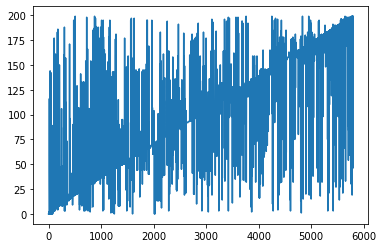

In [19]:
plt.plot(con_test_pred)

### Bug fixing 19.04.21

In [63]:
from ResNet34 import ResNet34

In [48]:
def create_org_model(train_generator, val_generator, input_shape=(224, 224, 3),  verbose=True, epochs=10, load=True):
    """Loads pretrain model or train one."""
    convlayers = ResNet34(input_shape=input_shape, input_tensor=None, weights='imagenet', include_top=False)
    dense1 = Dense(200,activation='softmax')

    model=Sequential()
    model.add(convlayers)
    model.add(AveragePooling2D(7,7))
    model.add(Flatten())
    model.add(dense1)
    optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    opt=tf.keras.optimizers.Adam(lr=0.0001)
    model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer=opt)
    
    if not load :
        history=model.fit_generator(train_generator,validation_data=val_generator,
         epochs=epochs, verbose=verbose)
        model.save_weights(model_dir+'complete_model.h5')
    else:
        model.load_weights(model_dir+'complete_model.h5')
    
    for layer in model.layers:
        layer.trainable = False
    
    feature_model =  Sequential()
    feature_model.add(convlayers)
    feature_model.add(AveragePooling2D(7,7))
    predict_model  =  Sequential()
    predict_model.add(Flatten())
    predict_model.add(dense1)

    return feature_model, predict_model, model

In [49]:
def new_train_generator(seed,percentage,df,org_datasetsize,repetition=30):
    np.random.seed(seed)
    indices = np.random.choice(org_datasetsize, size=int(percentage*org_datasetsize), replace=False)
    augmented_indices = indices.repeat(repetition)*repetition+np.tile(np.arange(repetition),len(indices))
    train_generator =train_datagen.flow_from_dataframe(dataframe=df.iloc[augmented_indices],
        directory=train_directory,
        x_col="x_col",
        y_col="y_col",
        target_size=(224,224),
        color_mode='rgb',
        shuffle=True,
        seed=seed,
        class_mode='sparse',batch_size=batch_size,
    )
    return train_generator, indices

In [50]:
class Weight(Layer):
    """Simple Weight class."""

    def __init__(self, dim, **kwargs):
        self.dim = dim
        super(Weight, self).__init__(**kwargs)

    def build(self, input_shape):
        # creates a trainable weight variable for this layer.
        self.kernel = self.add_weight(
            name='proj', shape=self.dim, initializer=init, trainable=True)
        super(Weight, self).build(input_shape)

    def call(self, x):
        return self.kernel

    def compute_output_shape(self, input_shape):
        return self.dim

def mean_sim(topic_prob_n,n_concept):
  """creates loss for topic model"""
  def loss(y_true, y_pred):
    return 1*tf.reduce_mean(input_tensor=tf.nn.top_k(K.transpose(K.reshape(topic_prob_n,(-1,n_concept))),k=32,sorted=True).values)
  return loss

In [51]:
def topic_model_new_BIRD(predict,
           f_train,
           y_train,
           n_concept,
           verbose=False,
           metric1=['accuracy'],
           opt='adam',
           loss1=tf.nn.softmax_cross_entropy_with_logits,
           thres=0.0,
           load=False):
    """Returns main function of topic model."""


    f_input = Input(shape=(f_train.shape[1],f_train.shape[2],f_train.shape[3]), name='f_input')
    f_input_n =  Lambda(lambda x:K.l2_normalize(x,axis=(3)))(f_input)

    topic_vector = Weight((f_train.shape[3], n_concept))(f_input)
    topic_vector_n = Lambda(lambda x: K.l2_normalize(x, axis=0))(topic_vector)
    topic_prob = Lambda(lambda x:K.dot(x[0],x[1]))([f_input, topic_vector_n])
    topic_prob_n = Lambda(lambda x:K.dot(x[0],x[1]))([f_input_n, topic_vector_n])
    topic_prob_mask = Lambda(lambda x:K.cast(K.greater(x,thres),'float32'))(topic_prob_n)
    topic_prob_am = Lambda(lambda x:x[0]*x[1])([topic_prob,topic_prob_mask])
    topic_prob_sum = Lambda(lambda x: K.sum(x, axis=3, keepdims=True)+1e-3)(topic_prob_am)
    topic_prob_nn = Lambda(lambda x: x[0]/x[1])([topic_prob_am, topic_prob_sum])

    rec_vector_1 = Weight((n_concept, 500))(f_input)
    rec_vector_2 = Weight((500, f_train.shape[3]))(f_input)
    rec_layer_1 = Lambda(lambda x:K.relu(K.dot(x[0],x[1])))([topic_prob_nn, rec_vector_1])
    rec_layer_2 = Lambda(lambda x:K.dot(x[0],x[1]))([rec_layer_1, rec_vector_2])
    pred = predict(rec_layer_2)
    topic_model_pr = Model(inputs=f_input, outputs=pred)
    topic_model_pr.layers[-1].trainable = False
    if opt =='sgd':
        optimizer = SGD(lr=0.001)
        optimizer_state = [optimizer.iterations, optimizer.lr,
              optimizer.momentum, optimizer.decay]
        optimizer_reset = tf.compat.v1.variables_initializer(optimizer_state)
    elif opt =='adam':
        optimizer = Adam(lr=0.001)
        optimizer_state = [optimizer.iterations, optimizer.lr, optimizer.beta_1,
                                 optimizer.beta_2, optimizer.decay]
        optimizer_reset = tf.compat.v1.variables_initializer(optimizer_state)
    metric1.append(mean_sim(topic_prob_n, n_concept))
    topic_model_pr.compile(
      loss=topic_loss_BIRD(topic_prob_n, topic_vector_n,  n_concept, f_input, loss1=loss1),
      optimizer=optimizer,metrics=metric1)
    #print(topic_model_pr.summary())
    if load:
        topic_model_pr.load_weights(load)
    return topic_model_pr, optimizer_reset, optimizer, topic_vector_n,  n_concept, f_input

In [52]:
def topic_loss_BIRD(topic_prob_n, topic_vector_n, n_concept, f_input, loss1):
  """creates loss for topic model"""
  def loss(y_true, y_pred):
    return (1.0*tf.reduce_mean(input_tensor=loss1(y_true, y_pred))\
            - 0.1*tf.reduce_mean(input_tensor=(tf.nn.top_k(K.transpose(K.reshape(topic_prob_n,(-1,n_concept))),k=32,sorted=True).values))
            + 0.1*tf.reduce_mean(input_tensor=(K.dot(K.transpose(topic_vector_n), topic_vector_n) - tf.eye(n_concept)))
            )
  return loss

In [60]:
base_architecture = 'BIRD_3ep_100cons'
percentage = 0.7
verbose = 0
n_concept = 100
batch_size = 128
org_epochs = 3
topic_epochs = 10

train_directory='../data/cup_200_cropped/train_cropped_augmented2'
org_train_directory='../data/cup_200_cropped/train_cropped'
test_directory='../data/cup_200_cropped/test_cropped'

train_datagen=ImageDataGenerator(rescale=1/255)
org_train_datagen=ImageDataGenerator(rescale=1/255)
test_datagen=ImageDataGenerator(rescale=1/255)

# Create the dataframe to sample from the augmented dataset
filenames = []
folders = os.listdir(train_directory)
for foldername in sorted(folders):
    files = os.listdir(train_directory+"/"+foldername)
    for filename in sorted(files):
        filenames.append(foldername+"/"+filename)
df = pd.DataFrame(filenames ,columns=["x_col"])
df["y_col"] = df["x_col"].map(lambda x: x.split(".")[0])

In [55]:
# Create the dataframe for the original dataset
filenames = []
folders = os.listdir(org_train_directory)
for foldername in sorted(folders):
    files = os.listdir(org_train_directory+"/"+foldername)
    for filename in sorted(files):
        filenames.append(foldername+"/"+filename)
org_df = pd.DataFrame(filenames ,columns=["x_col"])
org_df["y_col"] = org_df["x_col"].map(lambda x: x.split(".")[0])

In [56]:
org_train_generator =org_train_datagen.flow_from_dataframe(dataframe=org_df,
    directory=org_train_directory,
    x_col="x_col",
    y_col="y_col",
    target_size=(224,224),
    color_mode='rgb',
    shuffle=False,
    class_mode='sparse',batch_size=batch_size,
)

Found 5994 validated image filenames belonging to 200 classes.


In [57]:
# Create the dataframe for the test dataset
filenames = []
folders = os.listdir(test_directory)
for foldername in sorted(folders):
    files = os.listdir(test_directory+"/"+foldername)
    for filename in sorted(files):
        filenames.append(foldername+"/"+filename)
test_df = pd.DataFrame(filenames ,columns=["x_col"])
test_df["y_col"] = test_df["x_col"].map(lambda x: x.split(".")[0])

In [58]:
test_generator =test_datagen.flow_from_dataframe(dataframe=test_df,
    directory=test_directory,
    x_col="x_col",
    y_col="y_col",
    target_size=(224,224),
    color_mode='rgb',
    shuffle=False,
    class_mode='sparse',batch_size=batch_size,
)

Found 5794 validated image filenames belonging to 200 classes.


In [64]:
experiment_run = '1'
seed = int(experiment_run)
experiment_run = str(experiment_run) 
model_dir = './saved_models/' + base_architecture + '/' + experiment_run + '/'
#makedir(model_dir)
train_datagen=ImageDataGenerator(rescale=1/255)
train_generator, indices = new_train_generator(seed,percentage,df,org_datasetsize=len(org_df),repetition=30)
feature_model, predict_model, model = create_org_model(train_generator,test_generator, epochs=org_epochs, load=True)

Found 125850 validated image filenames belonging to 200 classes.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [65]:
batches = 0 
f_train = []
f_train_y = []
for x_batch, y_batch in train_generator:
    f_train_batch = feature_model.predict(x_batch)
    f_train.append(f_train_batch)
    f_train_y.append(y_batch)
    batches += 1
    #print(batches, end=', ')
    if batches >= len(train_generator):
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break
f_train = np.concatenate(f_train)
f_train_y = np.concatenate(f_train_y)

In [67]:
init = keras.initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=None)

In [88]:
topic_model_pr, optimizer_reset, optimizer, topic_vector,  n_concept, f_input = topic_model_new_BIRD(predict_model,
																		                                f_train[:-26],
																		                                f_train_y[:-26],
																		                                n_concept,
																		                                verbose=verbose,
																		                                metric1=['accuracy'],
																		                                loss1=tf.keras.losses.sparse_categorical_crossentropy,
																		                                thres=0.2,
																		                                load=False)

In [89]:
topic_model_pr.fit(f_train,f_train_y,batch_size=150,epochs=topic_epochs, verbose=2)

Train on 125850 samples
Epoch 1/10
125850/125850 - 7s - loss: 2.9053 - accuracy: 0.0055 - loss_1: 0.1498
Epoch 2/10
125850/125850 - 6s - loss: 1.6207 - accuracy: 0.0028 - loss_1: 0.1527
Epoch 3/10
125850/125850 - 6s - loss: 1.1296 - accuracy: 0.0042 - loss_1: 0.1516
Epoch 4/10
125850/125850 - 6s - loss: 0.8621 - accuracy: 0.0054 - loss_1: 0.1517
Epoch 5/10
125850/125850 - 7s - loss: 0.6864 - accuracy: 0.0049 - loss_1: 0.1521
Epoch 6/10
125850/125850 - 7s - loss: 0.5359 - accuracy: 0.0051 - loss_1: 0.1531
Epoch 7/10
125850/125850 - 6s - loss: 0.3828 - accuracy: 0.0054 - loss_1: 0.1548
Epoch 8/10
125850/125850 - 5s - loss: 0.2984 - accuracy: 0.0054 - loss_1: 0.1560
Epoch 9/10
125850/125850 - 7s - loss: 0.2261 - accuracy: 0.0053 - loss_1: 0.1577
Epoch 10/10
125850/125850 - 6s - loss: 0.1629 - accuracy: 0.0052 - loss_1: 0.1596


In [90]:
topic_model_pr.fit(f_train[:-26],f_train_y[:-26],batch_size=128,epochs=topic_epochs, verbose=2)

Train on 125824 samples
Epoch 1/10
125824/125824 - 7s - loss: 0.1215 - accuracy: 0.0052 - loss_1: 0.1556
Epoch 2/10
125824/125824 - 7s - loss: 0.0867 - accuracy: 0.0051 - loss_1: 0.1577
Epoch 3/10
125824/125824 - 8s - loss: 0.0640 - accuracy: 0.0051 - loss_1: 0.1598
Epoch 4/10
125824/125824 - 7s - loss: 0.0411 - accuracy: 0.0050 - loss_1: 0.1620
Epoch 5/10
125824/125824 - 7s - loss: 0.0228 - accuracy: 0.0050 - loss_1: 0.1645
Epoch 6/10
125824/125824 - 7s - loss: 0.0083 - accuracy: 0.0050 - loss_1: 0.1674
Epoch 7/10
125824/125824 - 7s - loss: 0.0021 - accuracy: 0.0050 - loss_1: 0.1696
Epoch 8/10
125824/125824 - 7s - loss: -3.1452e-03 - accuracy: 0.0050 - loss_1: 0.1725
Epoch 9/10
125824/125824 - 7s - loss: -7.0819e-03 - accuracy: 0.0050 - loss_1: 0.1759
Epoch 10/10
125824/125824 - 8s - loss: -9.2473e-03 - accuracy: 0.0050 - loss_1: 0.1790


In [74]:
int(len(f_train) /0.7) % 32

9

In [85]:
125850 /(5*5*3*2*839)

1.0

In [86]:
(5*5*3*2)

150